# Implement a custom pipeline

GPJax does not support sharing parameters across mean and kernel. Therefore, a custom model must be defined (in lieu of the traditional posterior) as well as a custom objective function (which is a modified `gpx.objectives.ConjugateMLL`) to perform a fit (obtain optimised posterior).

In [928]:
import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
from gpjax.base import param_field, static_field
from dataclasses import dataclass, field
import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.distributions import GaussianDistribution

from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
    Int,
)

import cola
from cola.ops import (
    Dense,
    LinearOperator,
)


import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp

from gpjax.dataset import Dataset

from beartype.typing import (
    Union,
)
import beartype.typing as tp

Kernel = tp.TypeVar("Kernel", bound="gpjax.kernels.base.AbstractKernel")
CustomModel = tp.TypeVar("Model", bound="p53_model")

import optax as ox
key = jr.PRNGKey(42)

In [929]:
# Add autoreleoad

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [930]:
# define model
@dataclass
class p53_model(gpx.base.Module):
    """
    Implementation of p53 model from Lawrence et al. 2006
    """
    # Define jitter (prior) and noise (likelihood)
    jitter: float = static_field(1e-6)
    obs_stddev: Union[ScalarFloat, Float[Array, "#N"]] = param_field(jnp.array(1.0), bijector=tfb.Softplus())

    ####### Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Restrict lengthscale to be between 0.5 and 3.5
    l_bijector = tfb.Sigmoid(low=0.5, high=3.5)

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, 
        bijector=l_bijector, 
        metadata={"name": "lengthscale"},
        trainable=True,
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(
        initial_constrained_b,
        bijector=tfb.Softplus(), 
        metadata={"name": " basal_rates"},
        trainable=True,
    )

    # Define mean function
    def mean_function(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        f = jnp.array(x[:,2:], dtype=int)
    
        num_genes = 5
        block_size = (x.shape[0] // num_genes)
        mean = (self.true_b / self.true_d).reshape(-1, 1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean * f
    
    # Define kernel
    def kernel(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))       

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2
    
    
    # Calculate cross-covariance
    def cross_covariance(
        self, kernel: Kernel, x: Float[Array, "N D"], y: Float[Array, "M D"]
    ) -> Float[Array, "N M"]:
        cross_cov = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(y))(x)
        
        return cross_cov

    def gram(self, kernel: Kernel, x: Float[Array, "N D"]) -> LinearOperator:
        Kxx = self.cross_covariance(kernel, x, x)
        
        return cola.PSD(Dense(Kxx))


    ############################
    # Define predict methods
    ############################
    
    def latent_predict(
        self, test_inputs: Num[Array, "N D"], train_data: JAXP53_Data
    ) -> GaussianDistribution:
    
        x, y, variances = dataset_3d(train_data)
        t = test_inputs
        #jitter = 1e-3

        mean_x = self.mean_function(x)
        mean_t = self.mean_function(t)

        diag_variances = jnp.diag(variances.reshape(-1))
        Kxx = self.gram(self.kernel, x)
        Kxx += diag_variances
        Kxx += cola.ops.I_like(Kxx) * self.jitter
        K_inv = cola.inv(Kxx)

        Kxf = self.cross_covariance(self.kernel, x, t)
        KfxKxx = jnp.matmul(Kxf.T, K_inv.to_dense())
        mean = mean_t + jnp.matmul(KfxKxx, y - mean_x)

        Kff = self.gram(self.kernel, t)
        Kff += cola.ops.I_like(Kff) * self.jitter

        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.diag(jnp.diag(var.to_dense()))
        var += cola.ops.I_like(var) * self.jitter

        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)
    
    def single_gene_predict(self, test_inputs: Num[Array, "N D"], gene: Int[Array, " O"], train_data: JAXP53_Data) -> GaussianDistribution:
        x, y, variances = dataset_3d(train_data)
        t = test_inputs
        obs_noise = self.obs_stddev ** 2

        t2 = t.at[:,2].set(1)
        t = t2

        mean_x = self.mean_function(x)

        # Slice traning data for given gene (not needed when multivariate)
        start_slice = (gene - 1) * 7
        end_slice = start_slice + 7

        x = x[start_slice:end_slice]
        y = y[start_slice:end_slice]
        variances = variances[start_slice:end_slice]
        mean_x = mean_x[start_slice:end_slice]

        diag_variances = jnp.diag(variances.reshape(-1))

        Kxx = self.gram(self.kernel, x)

        # Σ = Kxx + Io²
        Sigma = Kxx + diag_variances
        Sigma += cola.ops.I_like(Sigma) * obs_noise
        Sigma = cola.PSD(Sigma)

        mean_t = self.mean_function(t)
        Ktt = self.gram(self.kernel, t)
        Kxt = self.cross_covariance(self.kernel, x, t)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)

        # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
        mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, y - mean_x)

        # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt
        var = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        var += cola.ops.I_like(var) * self.jitter
        var = cola.PSD(var)

        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)
    

    def multi_gene_predict(self, test_inputs: Num[Array, "N D"], train_data: JAXP53_Data) -> GaussianDistribution:
        
        x, y, variances = dataset_3d(train_data)
        t = test_inputs


        t2 = t.at[:,2].set(1)
        #t2 = t
        
        obs_noise = self.obs_stddev ** 2
        mean_x = self.mean_function(x)

        diag_variances = jnp.diag(variances.reshape(-1))

        Kxx = self.gram(self.kernel, x)

        # Σ = Kxx + Io²
        Sigma = Kxx + diag_variances
        Sigma += cola.ops.I_like(Sigma) # * obs_noise
        Sigma = cola.PSD(Sigma)

        mean_t = self.mean_function(t)
        Ktt = self.gram(self.kernel, t)
        Kxt = self.cross_covariance(self.kernel, x, t)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)

        # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
        mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, y - mean_x)

        # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt
        var = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        var += cola.ops.I_like(var) * self.jitter
        var = cola.PSD(var)

        print(f' final mean and var shape: {mean.shape}, {var.shape}')

        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)
    


In [931]:
@dataclass
class CustomConjMLL(gpx.objectives.AbstractObjective):
    def step(self, model: CustomModel, train_data: Dataset) -> ScalarFloat:
        x, y = train_data.X, train_data.y

        obs_noise = model.obs_stddev ** 2
        mx = model.mean_function(x)

        # Σ = (Kxx + Io²) = LLᵀ
        Kxx = model.gram(model.kernel, x)
        Kxx += cola.ops.I_like(Kxx) * model.jitter
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)

        # p(y | x, θ), where θ are the model hyperparameters:
        mll = GaussianDistribution(jnp.atleast_1d(mx.squeeze()), Sigma)

        return self.constant * (mll.log_prob(jnp.atleast_1d(y.squeeze())).squeeze())

In [932]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [933]:
testing_times.shape

(100, 3)

In [934]:
dataset_train = gpx.Dataset(training_times, gene_expressions)
custom_posterior = p53_model(jitter=jnp.array(1e-4))
loss = CustomConjMLL(negative=True)

In [935]:
import gpjax as gpx
import jax
import jax.random as jr
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.bijectors as tfb

from dataclasses import dataclass, field
from jaxtyping import Float
from gpjax.base import param_field, static_field
from gpjax.kernels.stationary.utils import squared_distance

from gpjax.typing import (
    Array,
    ScalarFloat,
)

In [936]:
# Kxx
@dataclass
class gpjax_kxx(gpx.kernels.AbstractKernel):
    " Test kernel for kxx"

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1, 1, 1, 1, 1], dtype=jnp.float64))

    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4000, 0.4000, 0.4000, 0.4000, 0.4000], dtype=jnp.float64))

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

In [937]:
# Kxf
@dataclass
class gpjax_kxf2(gpx.kernels.AbstractKernel):
    " Test kernel for kxf"

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64))

    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64))

    l: Float[Array, "1 1"] = static_field(jnp.array(2.5, dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()
    
    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

In [938]:
# Kff
@dataclass
class gpjax_kff(gpx.kernels.AbstractKernel):
    "Test kernel for kxf"

    l: Float[Array, "1 1"] = static_field(jnp.array([2.5000], dtype=jnp.float64))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)


        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze()

In [939]:
import matplotlib.pyplot as plt
import numpy as np

kxx_og = gpjax_kxx()
kxf_og = gpjax_kxf2()
kff_og = gpjax_kff()

kxx_gpjax = kxx_og.cross_covariance(training_times, training_times)
kxf_gpjax = kxf_og.cross_covariance(training_times, testing_times)
kff_gpjax = kff_og.cross_covariance(testing_times, testing_times)

kxx_new = custom_posterior.cross_covariance(custom_posterior.kernel, training_times, training_times)

kxf_new = custom_posterior.cross_covariance(custom_posterior.kernel, training_times, testing_times)
kff_new = custom_posterior.cross_covariance(custom_posterior.kernel, testing_times, testing_times)

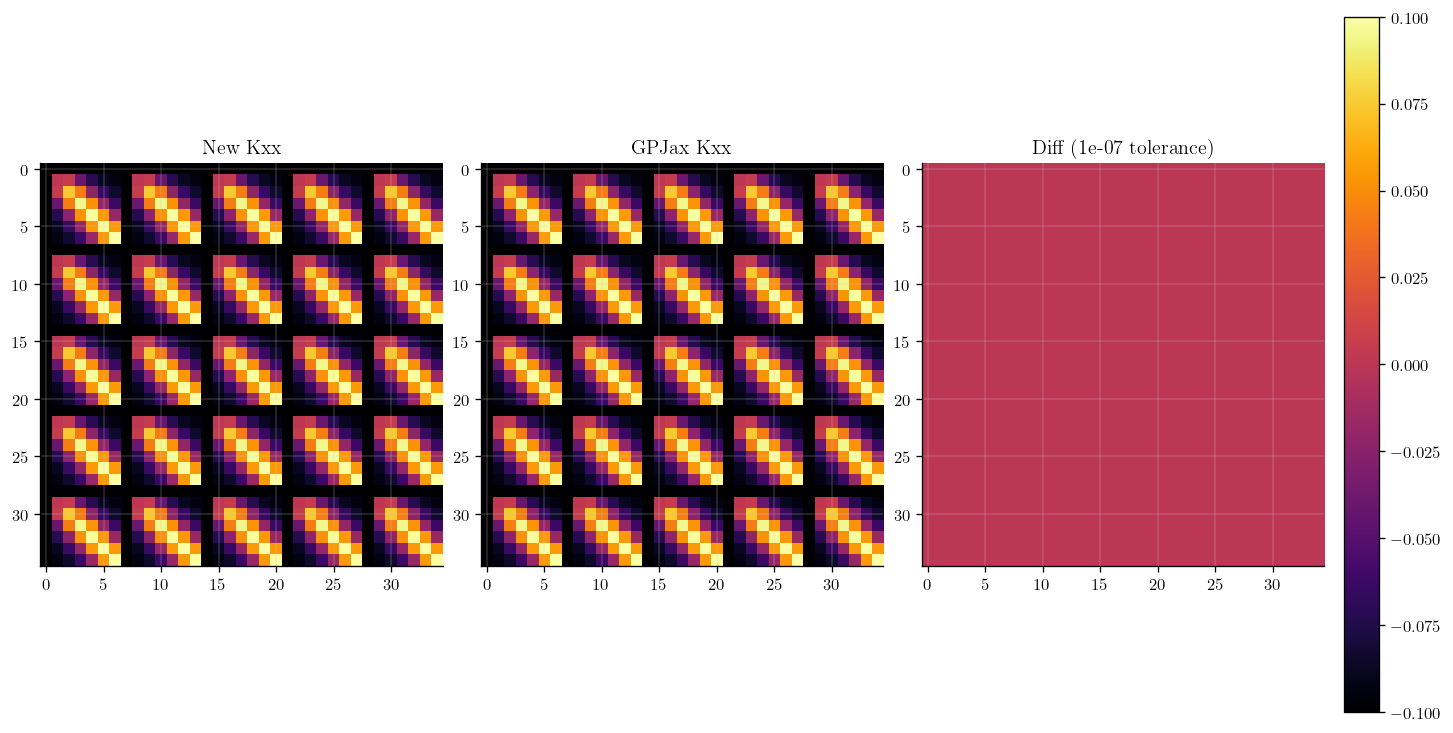

In [940]:
tol = 1e-7
diff_kxx = np.where(np.abs(kxx_gpjax - kxx_new) < tol, 0, kxx_gpjax - kxx_new)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(kxx_new)
plt.title("New Kxx")

plt.subplot(1, 3, 2)
plt.imshow(kxx_gpjax)
plt.title("GPJax Kxx")

plt.subplot(1, 3, 3)
plt.imshow(diff_kxx)
plt.title(f"Diff ({tol:.0e} tolerance)")

plt.colorbar()
plt.show()

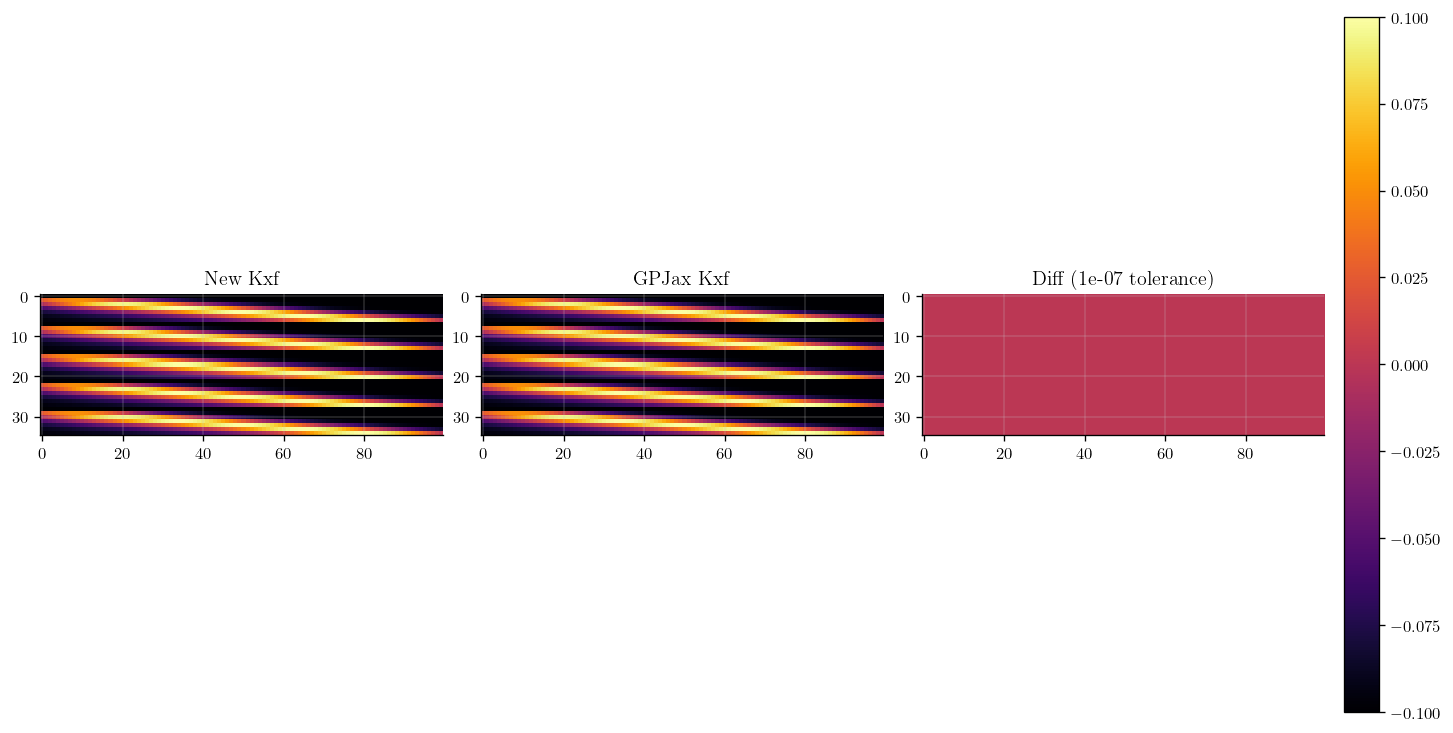

In [941]:
# Plot pytorch kxf next to GPJAX kxf
tol_kxf = 1e-7

#diff_kxx = np.where(np.abs(Kxx_torch.detach().numpy() - Kxx_noisy) < tol, 0, Kxx_torch.detach().numpy() - Kxx_noisy)

diff_kxf = np.where(np.abs(kxf_gpjax - kxf_new) < tol_kxf, 0, kxf_gpjax - kxf_new)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(kxf_new)
plt.title("New Kxf")

plt.subplot(1, 3, 2)
plt.imshow(kxf_gpjax)
plt.title("GPJax Kxf")

plt.subplot(1, 3, 3)
plt.imshow(diff_kxf)
plt.title(f"Diff ({tol_kxf:.0e} tolerance)")

plt.colorbar()
plt.show()

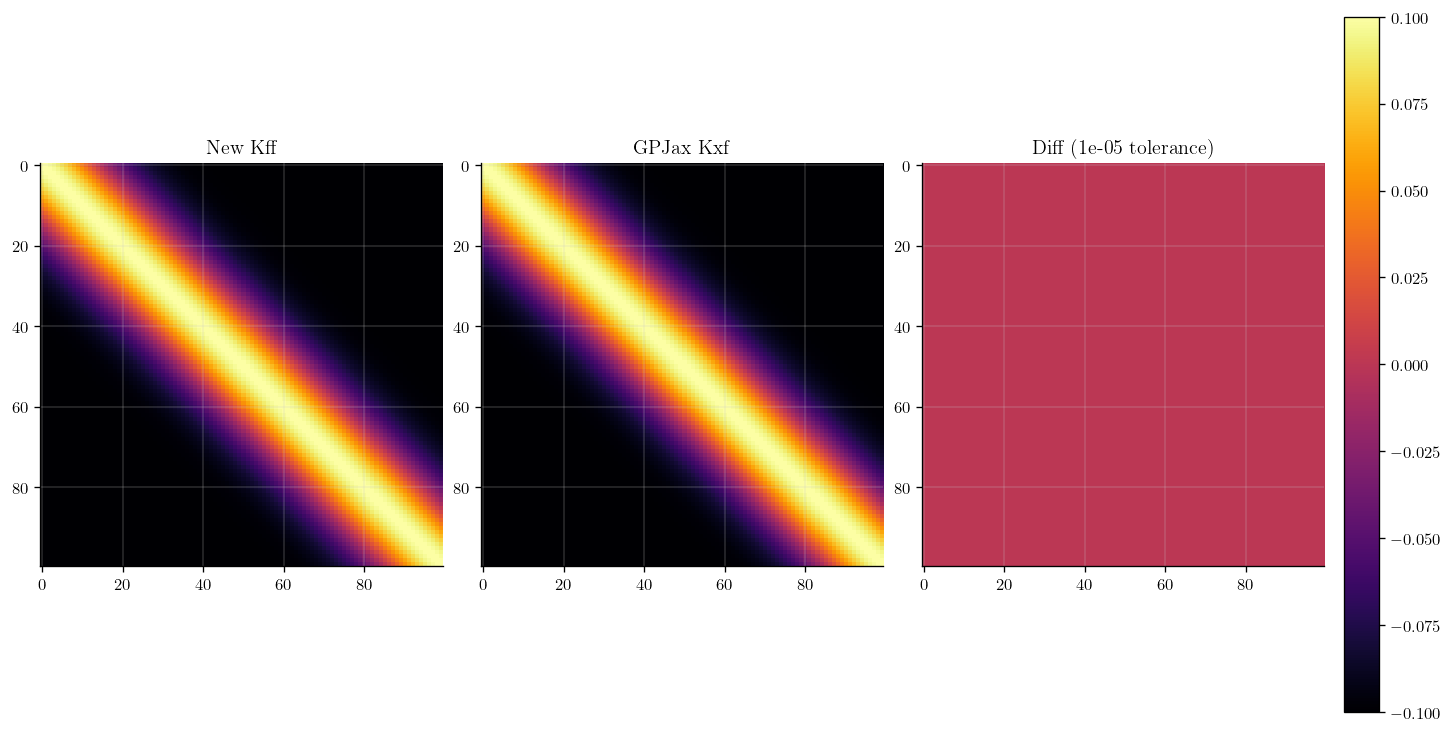

In [942]:
# Plot new kff next to GPJAX kff
tol_kff = 1e-5

diff_kff = np.where(np.abs(kff_gpjax - kff_new) < tol_kff, 0, kff_gpjax - kff_new)

plt.figure(figsize=(12, 6))
#fig, axs = plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(kff_new)
plt.title("New Kff")

plt.subplot(1, 3, 2)
plt.imshow(kff_gpjax)
plt.title("GPJax Kxf")

plt.subplot(1, 3, 3)
plt.imshow(diff_kff)
plt.title(f"Diff ({tol_kff:.0e} tolerance)")

plt.colorbar()
plt.show()

In [943]:
loss(custom_posterior, dataset_train)

Array(44.0322481, dtype=float64)

In [944]:
trained_model, history = gpx.fit(model=custom_posterior, objective=loss, train_data=dataset_train, optim=ox.adam(0.01), key=key, num_iters=100)

Running: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s, Value=24.60]


In [945]:
trained_model

p53_model(jitter=Array(0.0001, dtype=float64, weak_type=True), obs_stddev=Array(0.47791464, dtype=float64), true_s=Array([0.78469492, 0.77225568, 0.74133159, 0.95136805, 0.77194798],      dtype=float64), true_d=Array([0.24220677, 0.26155327, 0.25180098, 0.59332105, 0.26378688],      dtype=float64), l=Array(1.6350858, dtype=float64), true_b=Array([0.09177097, 0.01984712, 0.04165804, 0.03144076, 0.09020027],      dtype=float64))

In [946]:
latent_dist = trained_model.latent_predict(testing_times, p53_data)

In [947]:
latent_mean = latent_dist.mean()
latent_std = latent_dist.stddev()

In [948]:
f = p53_data.f_observed.squeeze()

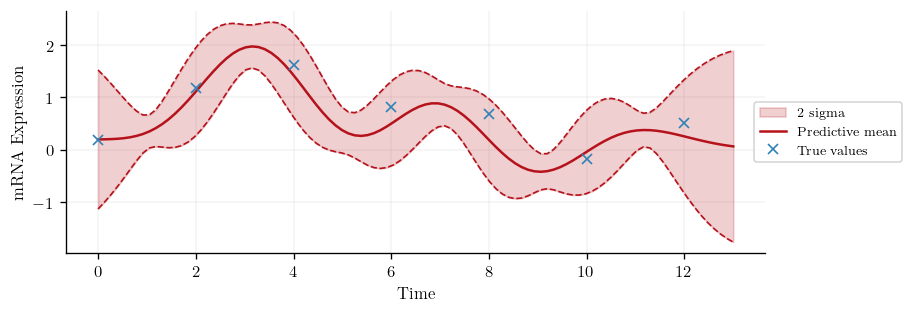

In [949]:
plot_gp(testing_times, latent_dist, y_scatter=f, stddev=2)

In [950]:
# Manipulate test times for single gene prediction
times = testing_times[:,0]
t = times.shape[0]
gene_indices = jnp.repeat(1, t)
testing_times_new = jnp.stack((times, gene_indices, jnp.repeat(1, t)), axis=-1)


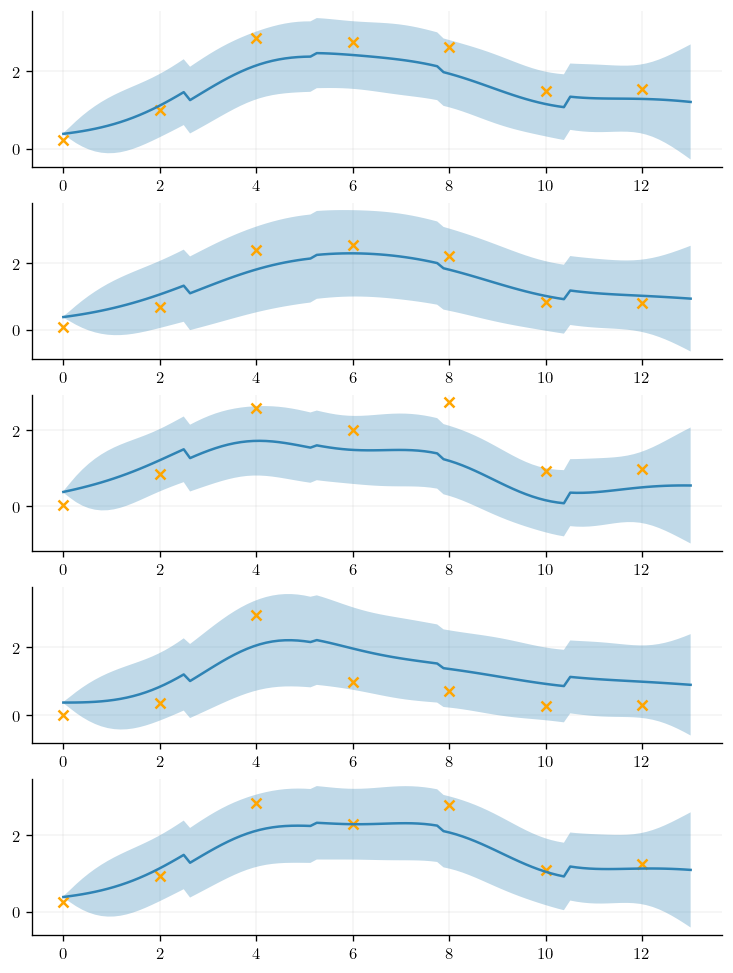

In [951]:
gene_1_dist = trained_model.single_gene_predict(testing_times, 1, p53_data)

# Plot gene expression

num_plots = 5
fig = plt.figure(figsize=(6, 4 * jnp.ceil(num_plots / 3)))

for i in range(num_plots):
    times = testing_times_new.at[:,1].set(i+1)
    gene_n_expression = trained_model.single_gene_predict(times,i+1, p53_data)
    mean_m = gene_n_expression.mean()
    std_m = gene_n_expression.stddev()

    ax = fig.add_subplot(num_plots, min(num_plots, 1), i + 1)
    #ax.plot(t_predict, mean_m[:, i], label=f"Gene {i+1}")
    ax.plot(testing_times[:,0], mean_m, label=f"Gene {i+1}")
    ax.fill_between(
        testing_times[:,0],
        mean_m - 2* std_m,
        mean_m + 2* std_m,
        alpha=0.3,
    )
    ax.scatter(p53_data.timepoints, p53_data.gene_expressions[:, i], color="orange", label="Training data")

In [952]:
def decompose_predictions(pred, X_test):
    """
    Decompose predictions into mean and variance per gene
    """
    num_genes = 5
    test_size = X_test.shape[0] // num_genes

    # Reshape predictions
    gene_1 = pred[:test_size]
    gene_2 = pred[test_size:test_size*2]
    gene_3 = pred[test_size*2:test_size*3]
    gene_4 = pred[test_size*3:test_size*4]
    gene_5 = pred[test_size*4:]

    return gene_1, gene_2, gene_3, gene_4, gene_5

In [953]:
def gene_xpr_test_times(testing_times):
    """ 
    Manipulate test times for gene expression predictions
    """

    times = testing_times[:,0]
    num_times = times.shape[0]
    times_repeated = jnp.tile(times, 5)
    gene_indices = jnp.repeat(jnp.arange(1, 6), num_times)
    
    new_times = jnp.stack((times_repeated, gene_indices, jnp.repeat(1, times_repeated.shape[0])), axis=1)
    return new_times

In [954]:
new_times = gene_xpr_test_times(testing_times)

# Save new_times to csv file
import pandas as pd
new_times_df = pd.DataFrame(new_times)

new_times_df.to_csv("new_times.csv", index=False)

In [955]:
gene_dists = trained_model.multi_gene_predict(new_times, p53_data)

 final mean and var shape: (500, 1), (500, 500)


In [956]:
gene_1_mean, gene_2_mean, gene_3_mean, gene_4_mean, gene_5_mean = decompose_predictions(gene_dists.mean(), new_times)

gene_1_std, gene_2_std, gene_3_std, gene_4_std, gene_5_std = decompose_predictions(gene_dists.stddev(), new_times)

In [957]:
gene_dists.mean().shape

(500,)

In [958]:
jnp.all(gene_1_mean == gene_2_mean)

Array(False, dtype=bool)

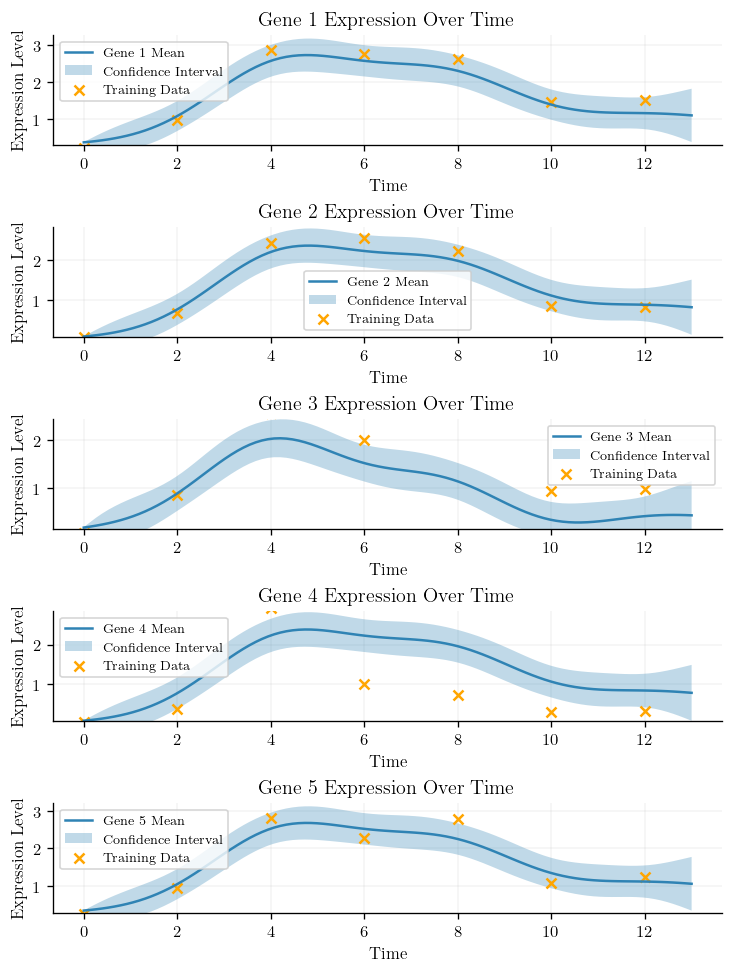

In [960]:
num_genes = 5
fig = plt.figure(figsize=(6, 4 * jnp.ceil(num_genes / 3)))

for i in range(num_genes):
    ax = fig.add_subplot(num_genes, min(num_genes, 1), i + 1)
    mean = eval(f'gene_{i+1}_mean')
    std = eval(f'gene_{i+1}_std')
    
    ax.plot(testing_times[:,0], mean, label=f"Gene {i+1} Mean")
    ax.fill_between(
        testing_times[:,0],
        mean - 1 * std,
        mean + 1 * std,
        alpha=0.3,
        label='Confidence Interval'
    )
    ax.scatter(p53_data.timepoints, p53_data.gene_expressions[:, i], color="orange", label="Training Data")
    # Set ylim
    lb = min(mean)
    lb -= 0.2 * lb
    ub = max(mean) * 1.2
    ax.set_ylim(lb, ub)

    ax.set_title(f"Gene {i+1} Expression Over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Expression Level")
    ax.legend()

plt.show()